<a href="https://colab.research.google.com/github/jo2lee/Machine-Learning/blob/main/Toronto%20COVID%20predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Looking at Toronto Covid19 Cases in 2020
##### Our goal in this project is to create a model of whether patients who still have COVID19 will survive or not based on the previous data. This data set was taken from Kaggle (https://www.kaggle.com/divyansh22/toronto-covid19-cases), however the data is not up-to-date. The reported cases with the patients' outcomes are from Jan 22, 2020 to June 30, 2020. There are patients that have the status 'ACTIVE' from June 30, 2020 to July 12, 2020. We would like to find out the ACTIVE patients' outcomes using the best model.

## Import dataset and libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

import os

# to make this notebook's output stable across runs
np.random.seed(1)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")



In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os
import pandas as pd
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1M51HZjFFHONXIdLJPkAjlABizTS4MX4x' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: TorontoCovid_MASTER.ipynb, id: 1lO-a5PsWHWj10AEcF7IlbXumrdcyPAZt
title: toronto_weather.xlsx, id: 1wfC0Xp8I4j706J9iuca9KipjD9M88BLK
title: Lucas TorontoCovid.ipynb, id: 1TLnSt3cSbDOiTmZqtPMbsa6sF5xh3m6d
title: neighbourhood-profiles-2016-csv.csv, id: 1oKweXbDdvAEjsPzEp6gT50xnjuSIVNfJ
title: Neighbourhood_Population.xlsx, id: 1emJZ439GN85T8VevJYsTjVQe81vSUB-g
title: Ideas, id: 1aOeyi1IHxF_QQclfBdAxssrgD6to-xl8rjC2ZCN8iqk
title: covidtoronto, id: 1c9y7F3ba4iIdj55Ng9bNYVRCoxGk2v9S
title: Copy of COVID19 cases Toronto.csv, id: 1GjsKQCdXMR06CeHA9268qxcJFp4Gfjzo
title: COVID19 cases Toronto.xlsx, id: 1Nkp2iHf4qm-PTBMPo1zJBM90oFg9TlYY


In [ ]:
data_downloaded = drive.CreateFile({'id': '1Nkp2iHf4qm-PTBMPo1zJBM90oFg9TlYY'})
data_downloaded.GetContentFile('COVID19 cases Toronto.xlsx')

data_downloaded = drive.CreateFile({'id': '1emJZ439GN85T8VevJYsTjVQe81vSUB-g'})
data_downloaded.GetContentFile('Neighbourhood_Population.xlsx')

data_downloaded = drive.CreateFile({'id': '1wfC0Xp8I4j706J9iuca9KipjD9M88BLK'})
data_downloaded.GetContentFile('toronto_weather.xlsx')


In [ ]:
#import data
df_covid_1=pd.read_excel('COVID19 cases Toronto.xlsx') #original file for COVID19 cases

df_pop=pd.read_excel('Neighbourhood_Population.xlsx') #neighbourhood population density data

df_temp_0=pd.read_excel('toronto_weather.xlsx', usecols = ['Date/Time', 'Mean Temp (°C)']) #Toronto Temperature data 
df_temp = df_temp_0.rename(columns={"Date/Time": "Reported Date", "Mean Temp (°C)": "Mean_temp_C"})
df_temp['Reported Date'] = pd.to_datetime(df_temp['Reported Date'])

In [ ]:
#merge density population and temperature into the covid dataset
df_1 = pd.merge (df_covid, df_temp, how = 'left', on = ["Reported Date"])

df = pd.merge (df_1, df_pop, how = 'left', on = ["Neighbourhood Name"])
df.head()


,_id,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated,Mean_temp_C,Population density per square kilometre
0,44294,Sporadic,50-59,Malvern,M1B,Institutional,CONFIRMED,2020-03-25,2020-03-27,MALE,RESOLVED,No,No,No,No,No,No,5.2,4948.0
1,44295,Sporadic,20-29,Malvern,M1B,Community,CONFIRMED,2020-03-20,2020-03-28,MALE,RESOLVED,No,No,No,Yes,No,No,5.3,4948.0
2,44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,2020-03-04,2020-03-08,FEMALE,RESOLVED,No,No,No,Yes,Yes,Yes,6.3,4948.0
3,44297,Outbreak Associated,50-59,Rouge,M1B,N/A - Outbreak associated,CONFIRMED,2020-05-02,2020-05-04,FEMALE,RESOLVED,No,No,No,No,No,No,6.6,1260.0
4,44298,Sporadic,30-39,Rouge,M1B,Close contact,CONFIRMED,2020-05-31,2020-06-06,FEMALE,RESOLVED,No,No,No,No,No,No,20.0,1260.0


## Describing Data Set

### Understanding the dataset with tables

In [ ]:
df.head() #dataset that include temperature and population density too

,_id,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated,Mean_temp_C,Population density per square kilometre
0,44294,Sporadic,50-59,Malvern,M1B,Institutional,CONFIRMED,2020-03-25,2020-03-27,MALE,RESOLVED,No,No,No,No,No,No,5.2,4948.0
1,44295,Sporadic,20-29,Malvern,M1B,Community,CONFIRMED,2020-03-20,2020-03-28,MALE,RESOLVED,No,No,No,Yes,No,No,5.3,4948.0
2,44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,2020-03-04,2020-03-08,FEMALE,RESOLVED,No,No,No,Yes,Yes,Yes,6.3,4948.0
3,44297,Outbreak Associated,50-59,Rouge,M1B,N/A - Outbreak associated,CONFIRMED,2020-05-02,2020-05-04,FEMALE,RESOLVED,No,No,No,No,No,No,6.6,1260.0
4,44298,Sporadic,30-39,Rouge,M1B,Close contact,CONFIRMED,2020-05-31,2020-06-06,FEMALE,RESOLVED,No,No,No,No,No,No,20.0,1260.0


In [ ]:
df.describe()

,_id,Mean_temp_C,Population density per square kilometre
count,14911.000000,14911.000000,14298.000000
mean,51749.000000,11.410757,6017.100643
std,4304.579267,7.852752,5689.071753
min,44294.000000,-8.900000,1040.000000
25%,48021.500000,5.100000,3130.000000
50%,51749.000000,10.300000,4691.000000
75%,55476.500000,18.400000,7197.000000
max,59204.000000,28.400000,44321.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14911 entries, 0 to 14910
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   _id                                      14911 non-null  int64         
 1   Outbreak Associated                      14911 non-null  object        
 2   Age Group                                14879 non-null  object        
 3   Neighbourhood Name                       14298 non-null  object        
 4   FSA                                      14344 non-null  object        
 5   Source of Infection                      14911 non-null  object        
 6   Classification                           14911 non-null  object        
 7   Episode Date                             14911 non-null  datetime64[ns]
 8   Reported Date                            14911 non-null  datetime64[ns]
 9   Client Gender                          

In [ ]:
df['Age Group'].value_counts().sort_values(ascending=False)

50-59             2354
20-29             2135
30-39             2101
40-49             2095
60-69             1598
80-89             1531
90+               1098
70-79             1052
19 and younger     915
Name: Age Group, dtype: int64

In [ ]:
df['Source of Infection'].value_counts().sort_values(ascending=False)

N/A - Outbreak associated    5578
Close contact                4998
Community                    1991
Healthcare                    897
Travel                        488
Unknown/Missing               364
Institutional                 301
Pending                       294
Name: Source of Infection, dtype: int64

In [ ]:
df['Classification'].value_counts().sort_values(ascending=False)

CONFIRMED    13686
PROBABLE      1225
Name: Classification, dtype: int64

In [ ]:
df['Client Gender'].value_counts().sort_values(ascending=False)

FEMALE         7909
MALE           6747
UNKNOWN         242
TRANSGENDER       7
OTHER             6
Name: Client Gender, dtype: int64

In [ ]:
df['Outcome'].value_counts().sort_values(ascending=False)

RESOLVED    13195
FATAL        1121
ACTIVE        595
Name: Outcome, dtype: int64

In [ ]:
df[df['_id']==44296]

,_id,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated,Mean_temp_C,Population density per square kilometre
2,44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,2020-03-04,2020-03-08,FEMALE,RESOLVED,No,No,No,Yes,Yes,Yes,6.3,4948.0


In [ ]:
df.groupby(['Reported Date','Outcome'])['Outcome'].count().head(20)

Reported Date  Outcome 
2020-01-23     RESOLVED     2
2020-02-21     RESOLVED     1
2020-02-25     RESOLVED     1
2020-02-26     RESOLVED     1
2020-02-27     RESOLVED     1
2020-02-28     RESOLVED     1
2020-02-29     RESOLVED     1
2020-03-01     RESOLVED     2
2020-03-02     RESOLVED     1
2020-03-03     RESOLVED     1
2020-03-04     RESOLVED     2
2020-03-05     RESOLVED     2
2020-03-06     RESOLVED     2
2020-03-07     RESOLVED     3
2020-03-08     FATAL        1
               RESOLVED     3
2020-03-09     RESOLVED     2
2020-03-10     RESOLVED     6
2020-03-11     RESOLVED    10
2020-03-12     RESOLVED    24
Name: Outcome, dtype: int64

### Understanding the data with Visualization

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text major ticklabel objects>)

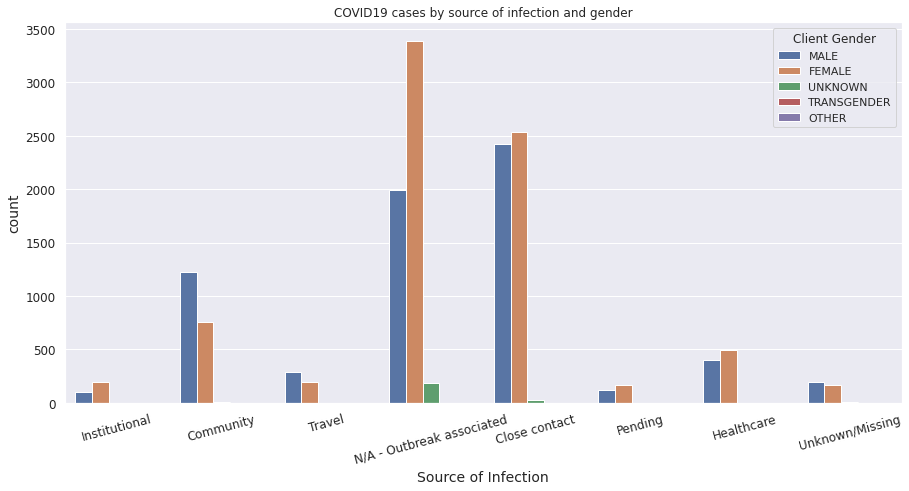

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x="Source of Infection", hue = 'Client Gender', data=df).set_title("COVID19 cases by source of infection and gender")
plt.xticks(rotation = 15)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

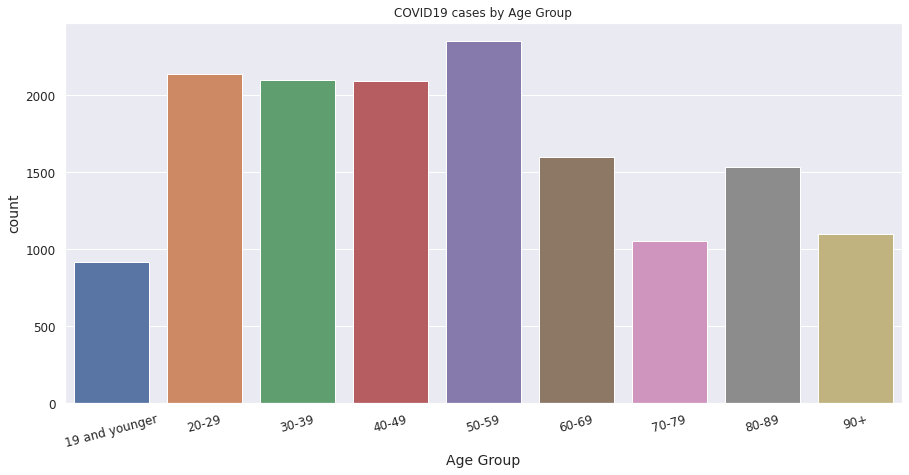

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x="Age Group", 
              order = ['19 and younger', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'],
                       data=df).set_title("COVID19 cases by Age Group")
plt.xticks(rotation = 15)

#### Does neighbourhood impact the the number of COVID19 cases?

We would like to see if the location would affect the number of people who caught COVID19 and to see their outcome, so we've gathered the population density data from the City of Toronto (https://open.toronto.ca/dataset/neighbourhood-profiles/).


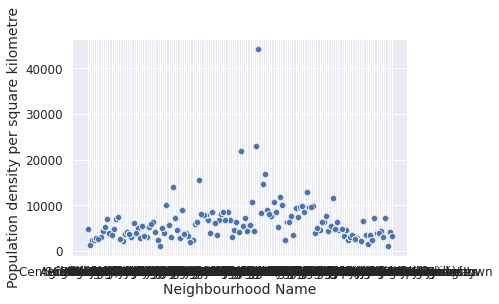

In [ ]:
sns.scatterplot(data=df, x="Neighbourhood Name", y="Population density per square kilometre") 
#seeing the spread of COVID cases within 140 neighbourhoods in Toronto

In [ ]:
pivot = df.pivot_table(index=['Neighbourhood Name'], values=['Population density per square kilometre'], aggfunc='mean')
pop_large = pivot.nlargest(5,'Population density per square kilometre') #gets 5 largest population densed neighbourhoods 
pop_small = pivot.nsmallest(5,'Population density per square kilometre')#gets 5 smallest population densed neighbourhoods 
pop_compare = pd.concat([pop_large, pop_small], keys='Neighbourhood Name')
pop_compare['Sort'] = ['Top 5', 'Top 5', 'Top 5', 'Top 5', 'Top 5', 'Bottom 5', 'Bottom 5', 'Bottom 5', 'Bottom 5', 'Bottom 5']
pop_compare

Population density per square kilometre      Sort
  Neighbourhood Name                                                                  
N North St. James Town                                               44321.0     Top 5
  Church-Yonge Corridor                                              23044.0     Top 5
  Mount Pleasant West                                                21969.0     Top 5
  Regent Park                                                        16880.0     Top 5
  Taylor-Massey                                                      15528.0     Top 5
e Bridle Path-Sunnybrook-York Mills                                   1040.0  Bottom 5
  West Humber-Clairville                                              1117.0  Bottom 5
  Rouge                                                               1260.0  Bottom 5
  Humber Summit                                                       1570.0  Bottom 5
  York University Heights                                             2086.0  Bottom 5

In [ ]:
pop_compare = pd.merge(pop_compare, df, how = 'left', on = ["Neighbourhood Name"])
pop_compare_pivot = pop_compare.pivot_table(index=['Neighbourhood Name'], aggfunc='count')
pop_compare_pivot

,Age Group,Classification,Client Gender,Currently Hospitalized,Currently Intubated,Currently in ICU,Episode Date,Ever Hospitalized,Ever Intubated,Ever in ICU,FSA,Mean_temp_C,Outbreak Associated,Outcome,Population density per square kilometre_x,Population density per square kilometre_y,Reported Date,Sort,Source of Infection,_id
Neighbourhood Name,,,,,,,,,,,,,,,,,,,,
Bridle Path-Sunnybrook-York Mills,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22,22
Church-Yonge Corridor,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89,89
Humber Summit,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137,137
Mount Pleasant West,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160,160
North St. James Town,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183,183
Regent Park,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31,31
Rouge,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303,303
Taylor-Massey,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82,82
West Humber-Clairville,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471,471


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

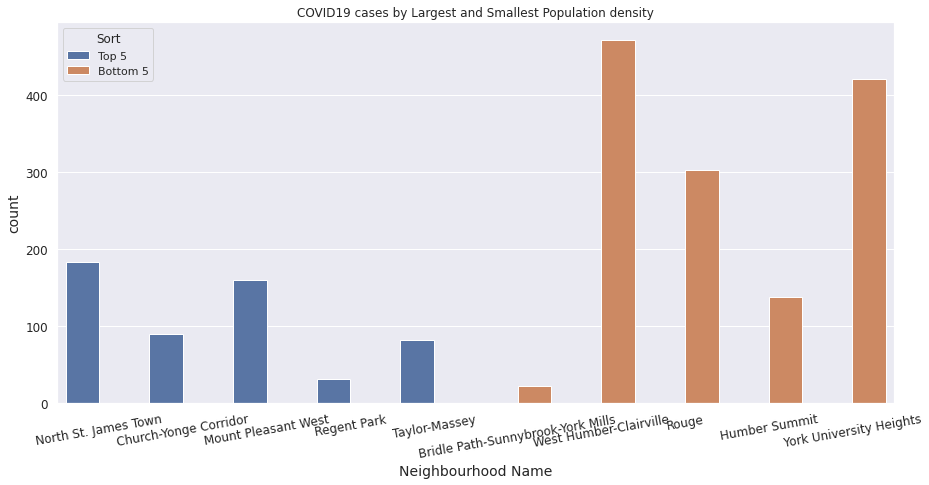

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x="Neighbourhood Name", 
              order = ['North St. James Town', 'Church-Yonge Corridor', 'Mount Pleasant West', 'Regent Park', 'Taylor-Massey', 'Bridle Path-Sunnybrook-York Mills', 'West Humber-Clairville', 'Rouge', 'Humber Summit', 'York University Heights'],
              hue = 'Sort',
              data=pop_compare).set_title("COVID19 cases by Largest and Smallest Population density")
plt.xticks(rotation = 10)

Text(0, 0.5, 'Count of COVID19 cases')

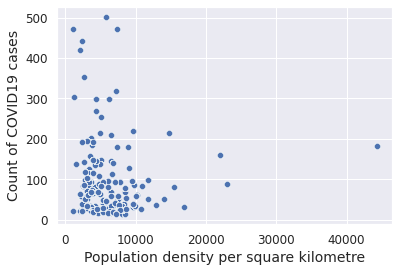

In [ ]:
pivot_1 = df.pivot_table(index=['Neighbourhood Name'],values=['Age Group'], aggfunc='count')
just_pop = df[['Neighbourhood Name', 'Population density per square kilometre']]
df_pop_count = pd.merge(pivot_1,just_pop, how = 'left', on = 'Neighbourhood Name')
df_pop_count
sns.scatterplot(data = df_pop_count, x='Population density per square kilometre', y= 'Age Group')
plt.ylabel('Count of COVID19 cases')

Shown above, there seems to be no correlation as to the Population density to the number of COVID 19 cases

### Understanding the Outcome (Resolved, Fatal, Active)

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

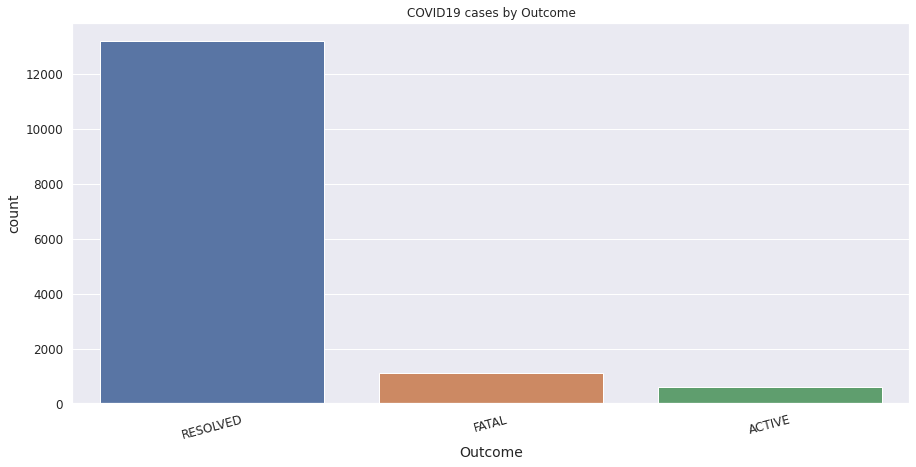

In [ ]:
plt.figure(figsize=(15,7))
sns.countplot(x="Outcome", data=df).set_title("COVID19 cases by Outcome")
plt.xticks(rotation = 15)

Shown above, there are very few "Active" cases. Our goal is to see wether those active patients will be resolved or not. First, let's see the attributes on the people who had a fatal outcome due to COVID19.

In [ ]:
fatal = df[df['Outcome'] == 'FATAL']
fatal['Age Group'].value_counts()

80-89             398
90+               366
70-79             208
60-69             103
50-59              34
40-49               9
20-29               1
19 and younger      1
30-39               1
Name: Age Group, dtype: int64

COVID19 is most fatal to people ages 80 and above

In [ ]:
fatal['Client Gender'].value_counts()

FEMALE         576
MALE           511
UNKNOWN         33
TRANSGENDER      1
Name: Client Gender, dtype: int64

## Creating the model

In [ ]:
df['Outcome'].unique()

array(['RESOLVED', 'FATAL', 'ACTIVE'], dtype=object)

In [ ]:
df=df.fillna("")
df.isnull().sum()

Res = df[df['Outcome'] == 'RESOLVED']
Fatal = df[df['Outcome'] == 'FATAL']
Active = df[df['Outcome'] == 'ACTIVE']
df_test = pd.concat([Res,Fatal]) ## Using RESOLVED and FATA data as our test data
test_outcome = {'RESOLVED': 1, 'FATAL': 0}
df_test['Outcome'] = df_test['Outcome'].map(test_outcome)
df_test.head()


,_id,Outbreak Associated,Age Group,Neighbourhood Name,FSA,Source of Infection,Classification,Episode Date,Reported Date,Client Gender,Outcome,Currently Hospitalized,Currently in ICU,Currently Intubated,Ever Hospitalized,Ever in ICU,Ever Intubated,Mean_temp_C,Population density per square kilometre
0,44294,Sporadic,50-59,Malvern,M1B,Institutional,CONFIRMED,2020-03-25,2020-03-27,MALE,1,No,No,No,No,No,No,5.2,4948
1,44295,Sporadic,20-29,Malvern,M1B,Community,CONFIRMED,2020-03-20,2020-03-28,MALE,1,No,No,No,Yes,No,No,5.3,4948
2,44296,Sporadic,60-69,Malvern,M1B,Travel,CONFIRMED,2020-03-04,2020-03-08,FEMALE,1,No,No,No,Yes,Yes,Yes,6.3,4948
3,44297,Outbreak Associated,50-59,Rouge,M1B,N/A - Outbreak associated,CONFIRMED,2020-05-02,2020-05-04,FEMALE,1,No,No,No,No,No,No,6.6,1260
4,44298,Sporadic,30-39,Rouge,M1B,Close contact,CONFIRMED,2020-05-31,2020-06-06,FEMALE,1,No,No,No,No,No,No,20.0,1260


### Using Random Forest Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



In [ ]:
target = 'Outcome'
features = df_test[['Outbreak Associated', 'Age Group', 'Neighbourhood Name', 'FSA',
       'Source of Infection', 'Classification', 'Client Gender', 'Currently Hospitalized',
       'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized',
       'Ever in ICU', 'Ever Intubated']]


In [ ]:
y = df_test.pop('Outcome')
X = features.astype(str)

In [ ]:
y.shape

(14316,)

In [ ]:
X.shape

(14316, 13)

In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = seed)

In [ ]:
X_train = X_train.fillna('na')
X_test = X_test.fillna('na')
X_train.dtypes

Outbreak Associated       object
Age Group                 object
Neighbourhood Name        object
FSA                       object
Source of Infection       object
Classification            object
Client Gender             object
Currently Hospitalized    object
Currently in ICU          object
Currently Intubated       object
Ever Hospitalized         object
Ever in ICU               object
Ever Intubated            object
dtype: object

In [ ]:
features_to_encode = list(X_train.select_dtypes(include = ['object']).columns) 

In [ ]:
#transforming the categorical variables, but does not touch the numerical ones

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
col_trans = make_column_transformer(
                        (OneHotEncoder(handle_unknown='ignore'),features_to_encode),
                        remainder = "passthrough"
                        )

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(
                      min_samples_leaf=50,
                      n_estimators=150,
                      bootstrap=True,
                      oob_score=True,
                      n_jobs=-1,
                      random_state=seed,
                      max_features='auto')

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(col_trans, rf_classifier)
pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=True),
                                                  ['Outbreak Associated',
                                                   'Age Group',
                                                   'Neighbourhood Name', 'FSA',
                                            

In [ ]:
y_pred = pipe.predict(X_test)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
#Getting accuracy of the train data
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 92.4 %


In [ ]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [ ]:
print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 0.9281251106480914
Test ROC AUC  Score: 0.915521798101143


In [ ]:
#using model to predict Active COVID19 patients' Outcomes

test = Active.fillna('na')
test = test[['Outbreak Associated', 'Age Group', 'Neighbourhood Name', 'FSA',
       'Source of Infection', 'Classification', 'Client Gender', 'Currently Hospitalized',
       'Currently in ICU', 'Currently Intubated', 'Ever Hospitalized',
       'Ever in ICU', 'Ever Intubated']]

test.shape

(595, 13)

In [ ]:
final_report = test
final_report['Outcome'] = pipe.predict(test)
final_report = final_report.loc[:,['Outcome']]

final_report= final_report.replace(1, 'RESOLVED')
final_report= final_report.replace(0, 'FATAL')

final_report.Outcome.value_counts()

RESOLVED    595
Name: Outcome, dtype: int64

In [ ]:
df=df.fillna("")
df.isnull().sum()

Res = df[df['Outcome'] == 'RESOLVED']
Fatal = df[df['Outcome'] == 'FATAL']
Active = df[df['Outcome'] == 'ACTIVE']
df_test = pd.concat([Res,Fatal]) ## Using RESOLVED and FATA data as our test data
df_test.head()

df_test.Outcome.value_counts(normalize=True)

RESOLVED    0.921696
FATAL       0.078304
Name: Outcome, dtype: float64

**Results**: Using the Random Forest Classifier in prediciting the test data (which are people with the "ACTIVE" status), we see that 595/595 people resolve from COVID19, meaning there are no fatal outcomes given a 92.5% accuracy. From our training data, we were expecting about 92% to resolve, and about 7% to have a fata outcome, though after running the model, it is giving us 100% resolved outcomes.